In [199]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
import nltk.corpus

res = requests.get("https://thehill.com/")
text = res.text

soup = BeautifulSoup(text, 'html.parser')

titles = []
for title in soup.find_all('a'):
    if title.get('title') != None and title.get('title') not in titles:
        titles.append(title.get('title'))


In [149]:
#Load cnn html using selenium because page is dynamic and need to get the source html
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time

PATH = "C:\Program Files (x86)\chromedriver.exe"

opts = Options()
#opts.set_headless() #keeps window closed
browser = webdriver.Chrome(PATH, options=opts) 
browser.get("https://www.cnn.com/") #run the site

cnnHtml = browser.page_source  #get the html

time.sleep(5)
browser.quit()

In [159]:
#Get fox html
res = requests.get('https://www.foxnews.com/')

foxHtml = res.text

In [174]:
foxSoup = BeautifulSoup(foxHtml, 'html.parser')

articles = foxSoup.find_all('h2', class_ = 'title title-color-default')

foxTitles = []
for title in articles:
    foxTitles.append(title.text)

In [220]:
#parsing the cnn titles
import re

cnnSoup = BeautifulSoup(cnnHtml, 'html.parser')

#Get headline elements
cnnTags = cnnSoup.find_all('span', class_="cd__headline-text vid-left-enabled")

#extract text content
cnnTitles = []
for title in cnnTags:
    cnnTitles.append(title.text)

In [223]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

theHillHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(titles)), 'headline': titles}).set_index('id')#load to dataframe
theHillHeadlines['source'] = 'The Hill'

cnnHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(cnnTitles)), 'headline': cnnTitles}).set_index('id')
cnnHeadlines['source'] = 'CNN'

foxHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(foxTitles)), 'headline': foxTitles}).set_index('id')
foxHeadlines['source'] = 'Fox'

headlines = pd.concat([theHillHeadlines, foxHeadlines, cnnHeadlines], axis=0)

headlines.head()


words = headlines['headline'].str.split(' ', expand=True).stack().reset_index(level=1).rename(columns={'level_1': 'position', 0: 'word'})

#remove punctuation
words['word'] = words['word'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


#filter stopwords out
words['word'] = words['word'].where(lambda x: ~x.isin(stopwords.words('english')))

words = words[words['word'].notna()]


#lemmatize words to remove plurals
def lem(x):
    lemmatizer = WordNetLemmatizer()
    lemmatized = lemmatizer.lemmatize(x)
    return lemmatized

words['word'] = words['word'].apply(lem)



In [232]:
#load dataframe of word -> sentiment value
sentiment = pd.read_csv('vader_lexicon.txt', sep='\t', index_col=0, names=['polarity', 'normalized_polarity', 'matrix'])
sentiment = sentiment.drop(columns = sentiment.columns.difference(['polarity']))

#Merge word sentiments with each word and replace nan with 0s to be neutral
polarities = words.merge(sentiment, left_on='word', right_index=True, how='left').fillna(0.0)

#Get sum of polarites for each title
sums = polarities.groupby(level=0)['polarity'].sum()

#Add polarity value back to each title
headlines['sentiment'] = sums
mean = headlines['sentiment'].mean()

print("Average sentiment of hill articles: " + str(mean))

headlines.sample(n=25)



Average sentiment of hill articles: 0.20085106382978712


,headline,source,sentiment
id,,,
9278808,Chinese official unveils future moon mission p...,The Hill,0.0
5210411,Trump's talk of martial law sends White House ...,CNN,0.0
2466371,India crowns new Miss Transqueen,CNN,0.0
2692636,Opinion,The Hill,0.0
350311,American people ‘desperately need’ coronavirus...,Fox,0.5
5646204,UK strain,CNN,-0.2
2664058,20 percent of US prisoners infected with COVID...,The Hill,-4.7
9684195,Fox News,CNN,0.0
9592582,Coalition of Black pastors slam Loeffler campa...,CNN,-3.7


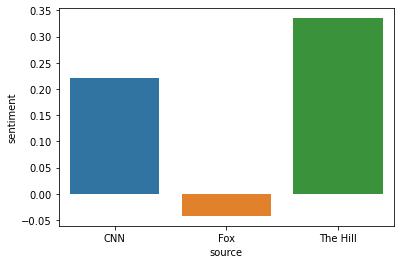

In [230]:
import seaborn as sns

meanSentiments = headlines.groupby('source').mean()

meanSentiments['sentiment']

sns.barplot(x=meanSentiments['sentiment'].index, y=meanSentiments['sentiment'])